In [9]:
import torch
import torchvision
import torchvision.datasets as datasets

In [2]:
torch.__version__

'1.9.0+cu111'

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.version.cuda

'11.1'

In [5]:
cuda_id = torch.cuda.current_device()

In [6]:
torch.cuda.current_device()

0

In [7]:
torch.cuda.get_device_name(cuda_id)

'NVIDIA GeForce GTX 1660 SUPER'

## Loading in the dataset

In [10]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9913344it [00:00, 9969783.05it/s]                              


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


29696it [00:00, ?it/s]                   


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




1649664it [00:00, 10339034.88it/s]                           
5120it [00:00, 5135063.72it/s]          

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw




c:\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [13]:
len(mnist_testset)

10000

In [35]:
import gzip
f = gzip.open('data/MNIST/raw/train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 5

import numpy as np
f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

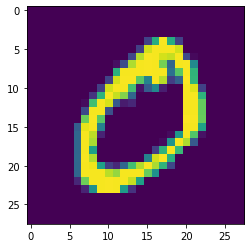

In [41]:
import matplotlib.pyplot as plt
image = np.asarray(data[1]).squeeze()
plt.imshow(image)
plt.show()

In [20]:
f = gzip.open('data/MNIST/raw/train-images-idx3-ubyte.gz','r')
f.read(8)
for i in range(0,50):   
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    print(labels)

[0]
[0]
[0]
[28]
[0]
[0]
[0]
[28]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
